In [1]:
import os
import cv2
import dlib
import numpy as np
from tqdm import tqdm

In [29]:
# Initialize dlib's face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('data_kaggle/shape_predictor_68_face_landmarks.dat')

def get_landmarks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects) > 0:
        shape = predictor(gray, rects[0])
        landmarks = np.array([[p.x, p.y] for p in shape.parts()])
        return landmarks
    return None

def pad_sequence(sequence, max_length):
    while len(sequence) < max_length:
        sequence.append(sequence[-1])
    return sequence

def load_and_preprocess_data(dataset_path):
    data = []
    labels = []
    max_length = 0
    i = 1
    # First pass to determine the maximum sequence length
    for person in tqdm(os.listdir(dataset_path)):
        person_path = os.path.join(dataset_path, person)
        words_path = os.path.join(person_path, 'words')
        if not os.path.isdir(words_path):
            continue
        print(i)
        i += 1
        for word in os.listdir(words_path):
            word_path = os.path.join(words_path, word)
            for example in os.listdir(word_path):
                example_path = os.path.join(word_path, example)
                landmarks_sequence = []
                for frame_file in os.listdir(example_path):
                    if frame_file.startswith('color'):
                        frame_path = os.path.join(example_path, frame_file)
                        image = cv2.imread(frame_path)
                        landmarks = get_landmarks(image)
                        if landmarks is not None:
                            landmarks_sequence.append(landmarks)
                if landmarks_sequence:
                    max_length = max(max_length, len(landmarks_sequence))

    i = 1
    # Second pass to load and pad the data
    for person in tqdm(os.listdir(dataset_path)):
        print(i)
        i += 1
        person_path = os.path.join(dataset_path, person)
        words_path = os.path.join(person_path, 'words')
        if not os.path.isdir(words_path):
            continue
        for word in os.listdir(words_path):
            word_path = os.path.join(words_path, word)
            for example in os.listdir(word_path):
                example_path = os.path.join(word_path, example)
                landmarks_sequence = []
                for frame_file in os.listdir(example_path):
                    if frame_file.startswith('color'):
                        frame_path = os.path.join(example_path, frame_file)
                        image = cv2.imread(frame_path)
                        landmarks = get_landmarks(image)
                        if landmarks is not None:
                            landmarks_sequence.append(landmarks)
                if landmarks_sequence:
                    padded_sequence = pad_sequence(landmarks_sequence, max_length)
                    data.append(padded_sequence)
                    labels.append(word)
        
    return np.array(data), np.array(labels)

dataset_path = 'data_kaggle/dataset/dataset/'
data, labels = load_and_preprocess_data(dataset_path)


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


100%|██████████| 1/1 [01:23<00:00, 83.20s/it]


In [49]:
w = []
w[:, 0].shape

IndexError: index 12 is out of bounds for axis 0 with size 12

In [60]:
def extract_lip_landmarks(data):
    lip_data = data[:, :, 48:68, :]
    return lip_data

lip_data = extract_lip_landmarks(data)


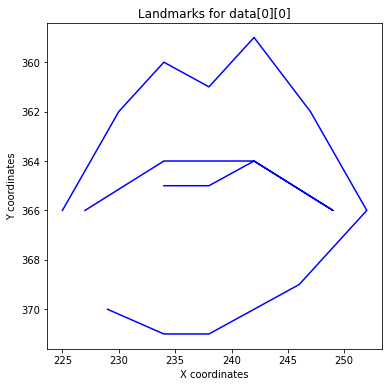

In [51]:
import matplotlib.pyplot as plt

def plot_landmarks(landmarks):
    plt.figure(figsize=(6, 6))

    outer_lip = landmarks[48:60]
    inner_lip = landmarks[60:68]
    
    # Plot each region

    plt.plot(outer_lip[:, 0], outer_lip[:, 1], c='blue')
    plt.plot(inner_lip[:, 0], inner_lip[:, 1], c='blue')
    
    plt.gca().invert_yaxis()
    plt.title('Landmarks for data[0][0]')
    plt.xlabel('X coordinates')
    plt.ylabel('Y coordinates')
    plt.show()

example_landmarks = data[0][0]
plot_landmarks(example_landmarks)


In [46]:
# np.save('data.npy', data)
# np.save('labels.npy', labels)

In [2]:
data = np.load('data.npy')
labels = np.load('labels.npy')

In [13]:
data.shape

(1500, 22, 68, 2)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

In [5]:
labels = np.array(labels).astype(int)

In [6]:
# Convert data and labels to PyTorch tensors
data_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Create a dataset and data loader
dataset = TensorDataset(data_tensor, labels_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




In [14]:
data_tensor.shape[2] * data_tensor.shape[3]

136

In [30]:
next(iter(train_loader))[0].shape

torch.Size([32, 22, 68, 2])

In [35]:
lstm_var = nn.LSTM(136, 256, batch_first=True, bidirectional=True)
h1, c1 = lstm_var(torch.randn(32, 22, 136))
print(h1.detach().numpy().shape)

(32, 22, 512)


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple RNN model
class LipReadingRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LipReadingRNN, self).__init__()
        self.hidden_size = hidden_size
        
        # Bidirectional LSTM layer
        self.bilstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        
        # Sequential container for fully connected layers with ReLU activations
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size * 2, 256),  # hidden_size * 2 because of bidirectional LSTM
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)  # 2 for bidirectional
        c0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.bilstm(x, (h0, c0))
        out = self.fc_layers(out[:, -1, :])
        
        return out

# Initialize the model, loss function, and optimizer
input_size = data_tensor.shape[2] * data_tensor.shape[3]
hidden_size = 128
num_classes = len(set(labels))
model = LipReadingRNN(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)



num_epochs = 100
model.train()
best_model = None
best_accuracy = 0.0
for epoch in range(num_epochs):
    total_loss = 0
    correct_train = 0
    total_train = 0
    
    model.train()
    for sequences, labels in train_loader:
        sequences = sequences.view(sequences.size(0), sequences.size(1), -1)  
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for sequences, labels in test_loader:
            sequences = sequences.view(sequences.size(0), sequences.size(1), -1)
            outputs = model(sequences)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        test_accuracy = 100 * correct / total
        print(f'Accuracy of the model on the test set: {test_accuracy:.2f}%')
        
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = model.state_dict()  

data

Epoch [1/100], Loss: 3.4835, Train Accuracy: 2.33%
Accuracy of the model on the test set: 9.00%
Epoch [2/100], Loss: 3.4251, Train Accuracy: 10.25%
Accuracy of the model on the test set: 9.00%
Epoch [3/100], Loss: 3.1364, Train Accuracy: 10.25%
Accuracy of the model on the test set: 9.00%
Epoch [4/100], Loss: 2.7435, Train Accuracy: 10.25%
Accuracy of the model on the test set: 9.00%
Epoch [5/100], Loss: 2.4571, Train Accuracy: 10.25%
Accuracy of the model on the test set: 9.00%
Epoch [6/100], Loss: 2.3444, Train Accuracy: 9.58%
Accuracy of the model on the test set: 9.67%
Epoch [7/100], Loss: 2.3257, Train Accuracy: 8.83%
Accuracy of the model on the test set: 8.33%
Epoch [8/100], Loss: 2.3158, Train Accuracy: 9.17%
Accuracy of the model on the test set: 9.00%
Epoch [9/100], Loss: 2.3170, Train Accuracy: 9.00%
Accuracy of the model on the test set: 8.33%
Epoch [10/100], Loss: 2.3161, Train Accuracy: 9.83%
Accuracy of the model on the test set: 8.33%
Epoch [11/100], Loss: 2.3128, Train

KeyboardInterrupt: 

In [42]:
print(labels)

tensor([ 3,  4,  2,  2,  9,  6,  5,  8,  2,  5, 10,  2,  8,  9,  4,  6, 10,  2,
         9,  9,  8,  6,  1,  8, 10,  3,  7,  8,  6,  6,  6,  5])


In [67]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for sequences, labels in test_loader:
        sequences = sequences.view(sequences.size(0), sequences.size(1), -1)
        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f'Accuracy of the model on the test set: {100 * correct / total:.2f}%')

Accuracy of the model on the test set: 43.67%
